# Partitioning the Dataset with Known and Unknown Lengths

The Context API allows you to specify when the lengths of the partitions are public and when they aren't. This section will clarify the trade-offs of partitioning with known and unknown lengths. 

## Set Up

In [1]:
import polars as pl 
import opendp.prelude as dp
import seaborn as sns 
import matplotlib.pyplot as plt

dp.enable_features("contrib")
sns.set_theme(style='darkgrid')

In [2]:
!curl "https://github.com/opendp/dp-test-datasets/blob/master/data/sample_FR_LFS.csv.zip?raw=true" -L -o data.zip

!unzip data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 5933k  100 5933k    0     0  1037k      0  0:00:05  0:00:05 --:--:-- 1147k
Archive:  data.zip
  inflating: sample_FR_LFS.csv       
  inflating: __MACOSX/._sample_FR_LFS.csv  


In [26]:
# Set ignore_errors to true to avoid conversion issues in len function. 
# Many columns contain mixtures of strings and numbers and cannot be parsed as floats.
df = pl.scan_csv("sample_FR_LFS.csv", ignore_errors=True)

# Defining a parameter that will be used in multiple contexts. 
estimated_max_partition_len = 60_000_000

CSV loading in a transformation is currently a work in progress in the OpenDP library, and the conversion errors are a potential privacy issue since the error reveals information about the data. 

The parameter `dp.polars.Margin.public_info` determines which properties of the grouped data are considered public information. 

There are 3 options for `dp.polars.Margin.public_info`: 

- `keys`: Designates keys that are not protected. 
- `lengths`: Designates that both keys and partition lengths are unprotected. 
- `None`: Designates that all information, including keys and lengths, is protected. 

In [27]:
context = dp.Context.compositor(
    data=df,
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=7,
    margins={
        ("AGE", ): dp.Margin(public_info=None,
                              max_partition_length=estimated_max_partition_len),
        ("YEAR", ): dp.Margin(public_info="keys",
                              max_partition_length=estimated_max_partition_len, 
                              max_partition_contributions=4, 
                              max_num_partitions=1),
        ("SEX","AGE","ILOSTAT", ): dp.Margin(public_info="keys",
                              max_partition_length=estimated_max_partition_len, 
                              max_partition_contributions=4, 
                              max_num_partitions=1),    
        (): dp.Margin(public_info= "lengths",
                      max_partition_length=estimated_max_partition_len, 
                      max_num_partitions=1),
    },
)

## Grouping By Private Keys

In a scenario where the grouping keys are clearly not private, such as social security numbers, `public_info` should be set to `None` to protect all available information. In this case, the variable `AGE` will be treated as a private key. 

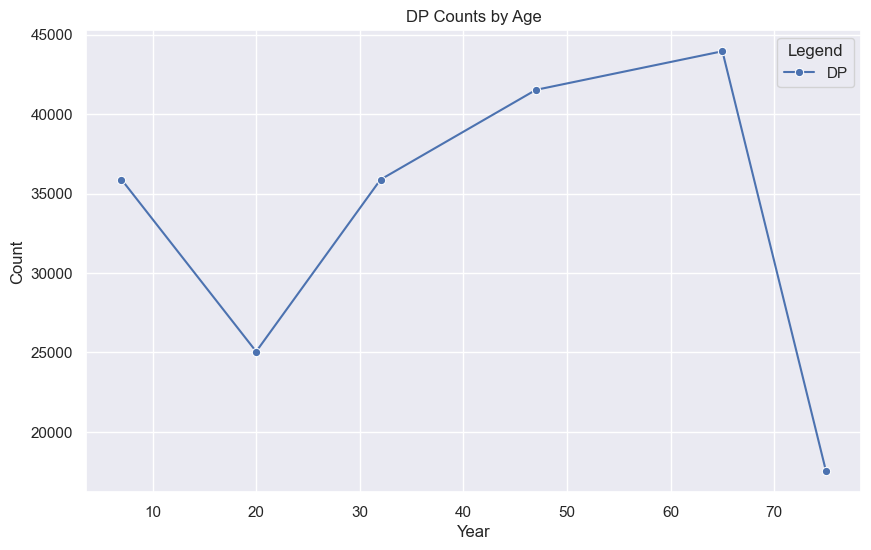

In [28]:
count_age_q = (
    context.query().group_by("AGE").agg(
        pl.len().dp.noise().alias("DP Count")
    ).sort("AGE"))
count_age_dp = count_age_q.release().collect()

plt.figure(figsize=(10, 6))
sns.lineplot(x=count_age_dp["AGE"].to_list(), y=count_age_dp["DP Count"].to_list(), marker="o", label="DP")
plt.title('DP Counts by Age')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Legend')
plt.show()

Grouping by private keys may also be useful when grouping by many pseudo-identifiers because the keys may reveal private information. The following example can demonstrate that by grouping by sex, age, country of birth, and their sequence number in the household. 

In [29]:
count_many_dp = (
    context.query().group_by(["SEX","AGE", "ILOSTAT"]).agg(
        pl.len().dp.noise().alias("DP Count")
    )).release().collect()

# Drop any rows with NA for clean visualization. 
count_many_dp = count_many_dp.drop_nulls()

count_many_dp

SEX,AGE,ILOSTAT,DP Count
i64,f64,i64,u32
1,32.0,1,15162
2,65.0,3,17883
2,20.0,3,7570
2,65.0,2,648
2,20.0,1,3069
…,…,…,…
1,7.0,9,18132
2,75.0,3,11155
1,47.0,2,1119


## Grouping By Private Lengths

To group by private keys, set the `public_info` parameter to `keys.` The group identifiers are treated as public information, and the partition length is protected. This allows queries such as the following that depend on count to be run and satisfy a DP guarantee. 


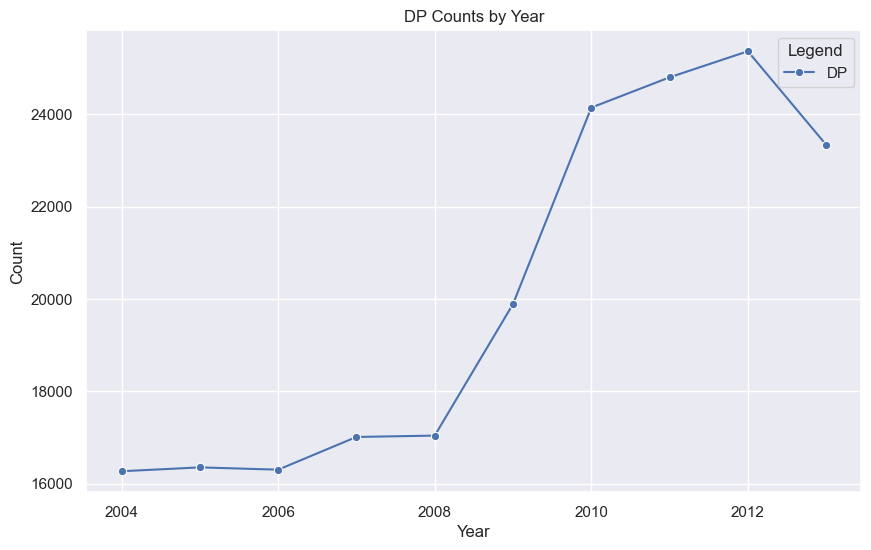

In [30]:
count_year_dp = (
    context.query().group_by("YEAR").agg(
        pl.len().dp.noise().alias("DP Count")
    ).sort("YEAR")).release().collect()

plt.figure(figsize=(10, 6))
sns.lineplot(x=count_year_dp["YEAR"].to_list(), y=count_year_dp["DP Count"].to_list(), marker="o", label="DP")
plt.title('DP Counts by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Legend')
plt.show()

This query wouldn't run if the parameter `public_info` were set to `lengths` because the partition length would be considered public and the DP mechanisms would not provide an adequate guarantee. 

However, in scenarios, such as computing the `sum`, that do not depend on the partition length being public, the query that still specifies the lengths to be public will have a higher utility due to more information being available at the cost of less privacy. 

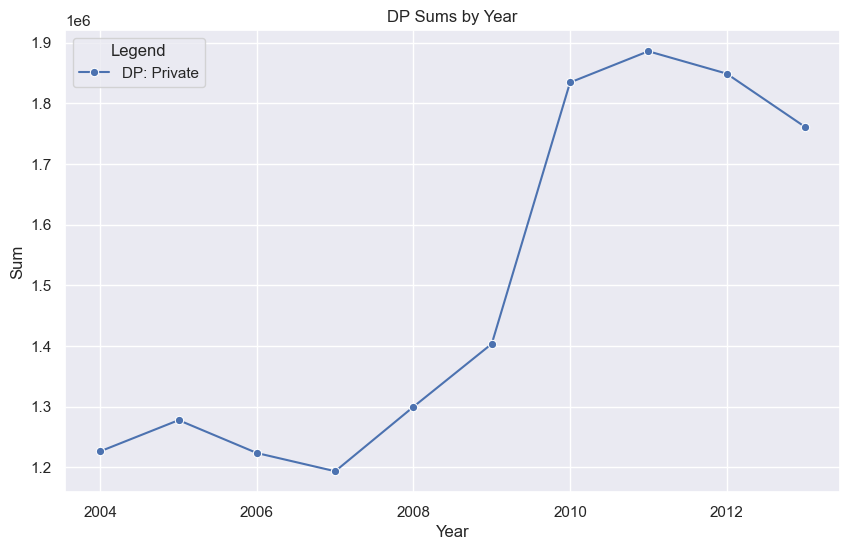

In [31]:
sum_year_dp = (
    context.query().group_by("YEAR").agg(
        pl.col("HWUSUAL").fill_null(40.).dp.sum((0,100)).alias("DP Sum")
    ).sort("YEAR")).release().collect()

plt.figure(figsize=(10, 6))
sns.lineplot(x=sum_year_dp["YEAR"].to_list(), y=sum_year_dp["DP Sum"].to_list(), marker="o", label="DP: Private")
plt.title('DP Sums by Year')
plt.xlabel('Year')
plt.ylabel('Sum')
plt.legend(title='Legend')
plt.show()

## Grouping By Public Lengths

Queries whose functions don't depend on the partition length may not have a significantly different utility if the `public_info` parameter is public or private. 

One example scenario is the sum of total hours worked per year where the data is being aggregated over a specific key and the noise addition is independent of the partition lengths being revealed. 

However, be cautious when you allow the parameter to be public and enable it to be public only in settings where you are confident the partition length will not reveal any sensitive information. 


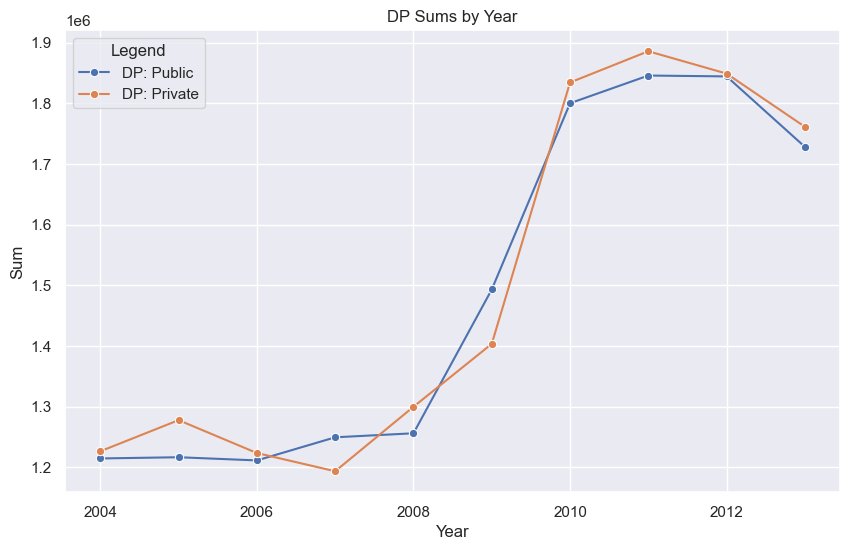

In [32]:
context = dp.Context.compositor(
    data=df,
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=5,
    margins={
        ("YEAR", ): dp.Margin(public_info="lengths",
                              max_partition_length=estimated_max_partition_len, 
                              max_partition_contributions=4, 
                              max_num_partitions=1),
                    
        (): dp.Margin(public_info= "lengths",
                      max_partition_length=estimated_max_partition_len, 
                      max_num_partitions=1),
    },
)

sum_year_dp_public = (
    context.query().group_by("YEAR").agg(
        pl.col("HWUSUAL").fill_null(40.).dp.sum((0,100)).alias("DP Sum")
    ).sort("YEAR")).release().collect()

plt.figure(figsize=(10, 6))
sns.lineplot(x=sum_year_dp_public["YEAR"].to_list(), y=sum_year_dp_public["DP Sum"].to_list(), marker="o", label="DP: Public")
sns.lineplot(x=sum_year_dp["YEAR"].to_list(), y=sum_year_dp["DP Sum"].to_list(), marker="o", label="DP: Private")
plt.title('DP Sums by Year')
plt.xlabel('Year')
plt.ylabel('Sum')
plt.legend(title='Legend')
plt.show()

The DP values computed with private lengths follow a similar trend as the DP values computed with public lengths. 

In this particular example, revealing the partition lengths may not appear consequential. However, sometimes they may indicate the number of individuals in a particular category or be misinterpreted leading to incorrect results.  